# Descripción
Un avión vuela con velocidad 
$V$
 a 
$Ha$
 metros del suelo en dirección a un cañón como se muestra en la figura.

El cañón tiene forma de trapecio isósceles invertido, de una altura 
$H
c$
, largo 
$L$
 y ángulo 
$α$
 con respecto al horizonte.

Cuando se encuentra a una distancia 
$d$
 del borde del cañón, el avión suelta una bomba.

![Imagen](im2.png)



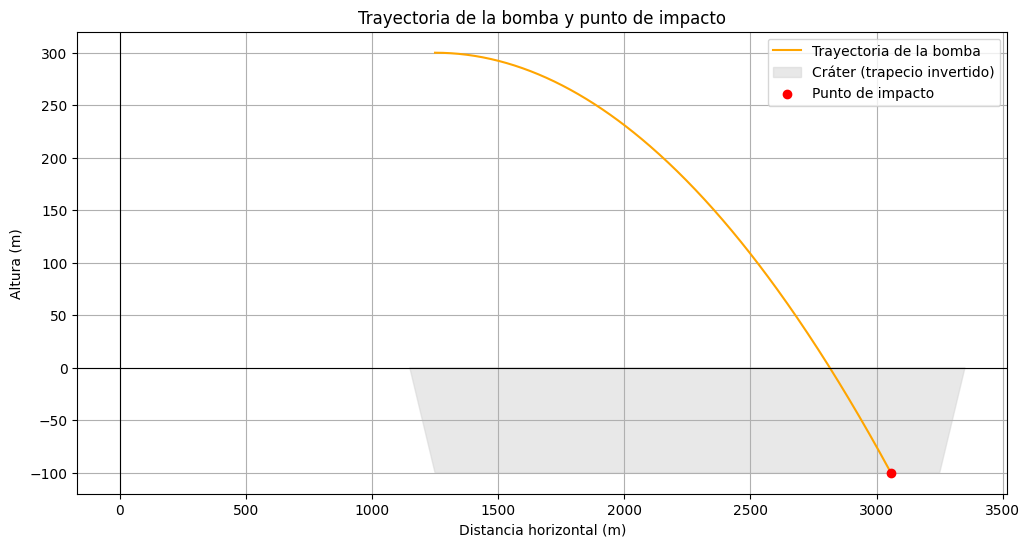

Punto de impacto: x = 3056.31 m, y = -100.00 m


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#
ha = 300
hc = -100
L = 2000
alpha = np.radians(45)
d = 1250
v0 = 200

v0x = v0
v0y = 0

g = 9.81
def trayectoria(x, x0, y0, v0x, v0y):
    t = (x - x0) / v0x
    return y0 + v0y * t - 0.5 * g * t**2

x_crater = [
    d,
    d + (hc / np.tan(alpha)),
    d + L - (hc / np.tan(alpha)),
    d + L
]
y_crater = [hc, 0, 0, hc]

x0 = d
y0 = ha
x_trayectoria = np.linspace(x0, x0 + L + 2 * d, 1000)
y_trayectoria = trayectoria(x_trayectoria, x0, y0, v0x, v0y)

impacto_x = None
for i in range(len(x_trayectoria)):
    if y_trayectoria[i] <= hc:
        impacto_x = x_trayectoria[i]
        impacto_y = hc
        break

if impacto_x and impacto_y:
    x_trayectoria_recortada = x_trayectoria[x_trayectoria <= impacto_x]
    y_trayectoria_recortada = y_trayectoria[:len(x_trayectoria_recortada)]
    
    plt.figure(figsize=(12, 6))
    plt.plot(x_trayectoria_recortada, y_trayectoria_recortada, label="Trayectoria de la bomba", color="orange")
    plt.fill(x_crater, y_crater, color="lightgrey", label="Cráter (trapecio invertido)", alpha=0.5)

    plt.scatter(impacto_x, impacto_y, color="red", label="Punto de impacto", zorder=5)

    plt.axhline(0, color="black", linewidth=0.8)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title("Trayectoria de la bomba y punto de impacto")
    plt.xlabel("Distancia horizontal (m)")
    plt.ylabel("Altura (m)")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Punto de impacto: x = {impacto_x:.2f} m, y = {impacto_y:.2f} m")
else:
    print("La bomba no impactó dentro del cráter.")


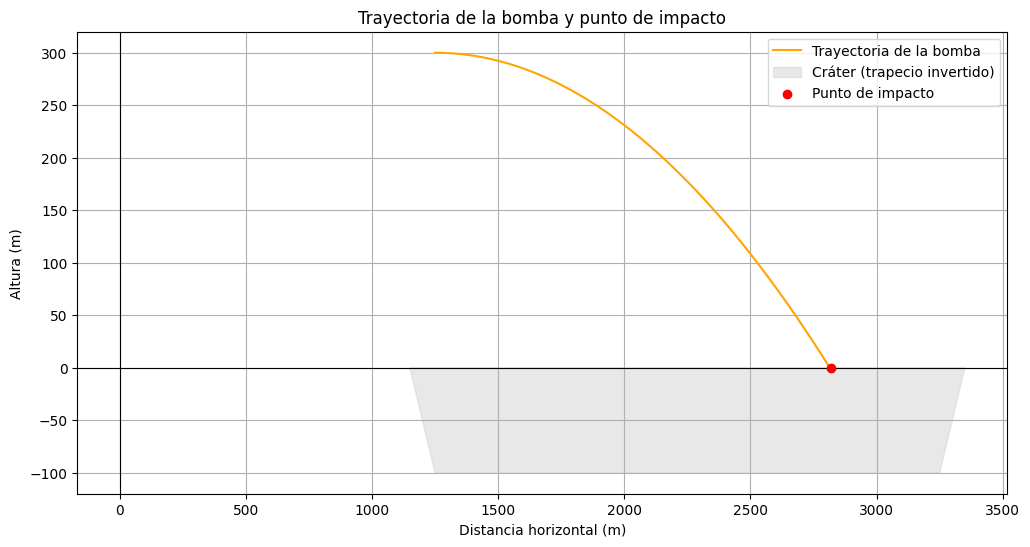

Punto de impacto: x = 2817.57 m, y = 0.00 m


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#hola

# Parámetros iniciales
ha = 300  # Altura inicial de la bomba
hc = -100  # Profundidad del cráter
L = 2000  # Longitud del cráter
alpha = np.radians(45)  # Ángulo del cráter en radianes
d = 1250  # Distancia inicial desde el punto de lanzamiento hasta el inicio del cráter
v0 = 200  # Velocidad inicial

# Componentes de la velocidad inicial
v0x = v0  # Velocidad horizontal
v0y = 0   # Velocidad vertical inicial

g = 9.81  # Aceleración gravitacional

# Función para calcular la trayectoria
def trayectoria(x, x0, y0, v0x, v0y):
    t = (x - x0) / v0x
    return y0 + v0y * t - 0.5 * g * t**2

# Función para calcular la altura del cráter en función de x
def altura_crater(x):
    if d <= x <= d + (hc / np.tan(alpha)):  # Lado izquierdo del cráter
        return np.tan(alpha) * (x - d)
    elif d + (hc / np.tan(alpha)) < x < d + L - (hc / np.tan(alpha)):  # Fondo plano
        return 0
    elif d + L - (hc / np.tan(alpha)) <= x <= d + L:  # Lado derecho del cráter
        return np.tan(-alpha) * (x - (d + L))
    return None  # Fuera del cráter

# Coordenadas del cráter
x_crater = [
    d,
    d + (hc / np.tan(alpha)),
    d + L - (hc / np.tan(alpha)),
    d + L
]
y_crater = [hc, 0, 0, hc]

# Trayectoria de la bomba
x0 = d
y0 = ha
x_trayectoria = np.linspace(x0, x0 + L + 2 * d, 1000)
y_trayectoria = trayectoria(x_trayectoria, x0, y0, v0x, v0y)

# Buscar el punto de impacto
impacto_x = None
impacto_y = None

for i in range(len(x_trayectoria)):
    x_actual = x_trayectoria[i]
    y_actual = y_trayectoria[i]
    y_crater_actual = altura_crater(x_actual)

    if y_crater_actual is not None and y_actual <= y_crater_actual:  # Impacto con el cráter
        impacto_x = x_actual
        impacto_y = y_crater_actual
        break
    elif y_actual <= 0:  # Impacto con el eje x
        impacto_x = x_actual
        impacto_y = 0
        break

# Visualización
if impacto_x is not None and impacto_y is not None:
    x_trayectoria_recortada = x_trayectoria[x_trayectoria <= impacto_x]
    y_trayectoria_recortada = y_trayectoria[:len(x_trayectoria_recortada)]
    
    plt.figure(figsize=(12, 6))
    plt.plot(x_trayectoria_recortada, y_trayectoria_recortada, label="Trayectoria de la bomba", color="orange")
    plt.fill(x_crater, y_crater, color="lightgrey", label="Cráter (trapecio invertido)", alpha=0.5)

    plt.scatter(impacto_x, impacto_y, color="red", label="Punto de impacto", zorder=5)

    plt.axhline(0, color="black", linewidth=0.8)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title("Trayectoria de la bomba y punto de impacto")
    plt.xlabel("Distancia horizontal (m)")
    plt.ylabel("Altura (m)")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Punto de impacto: x = {impacto_x:.2f} m, y = {impacto_y:.2f} m")
else:
    print("No se encontró un impacto dentro del rango calculado.")


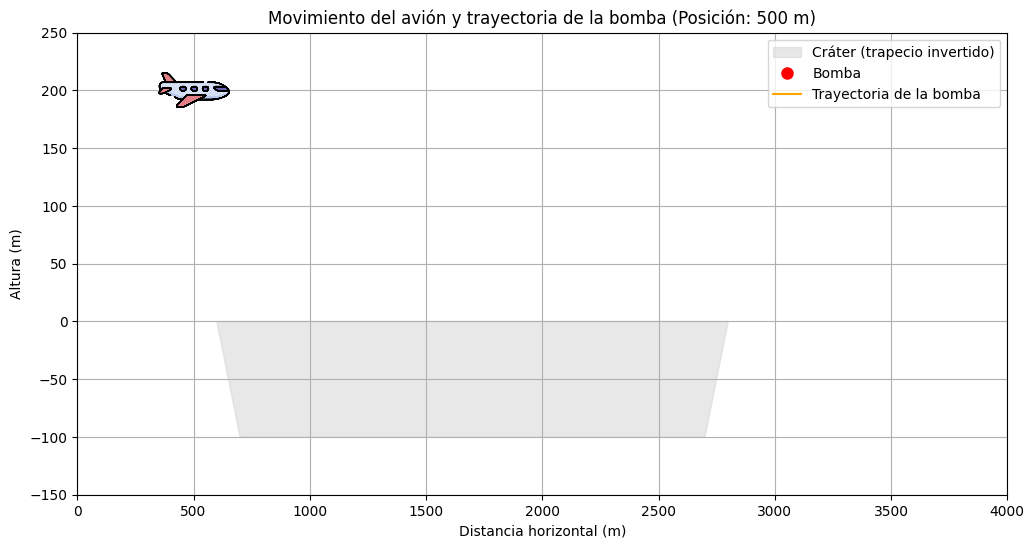

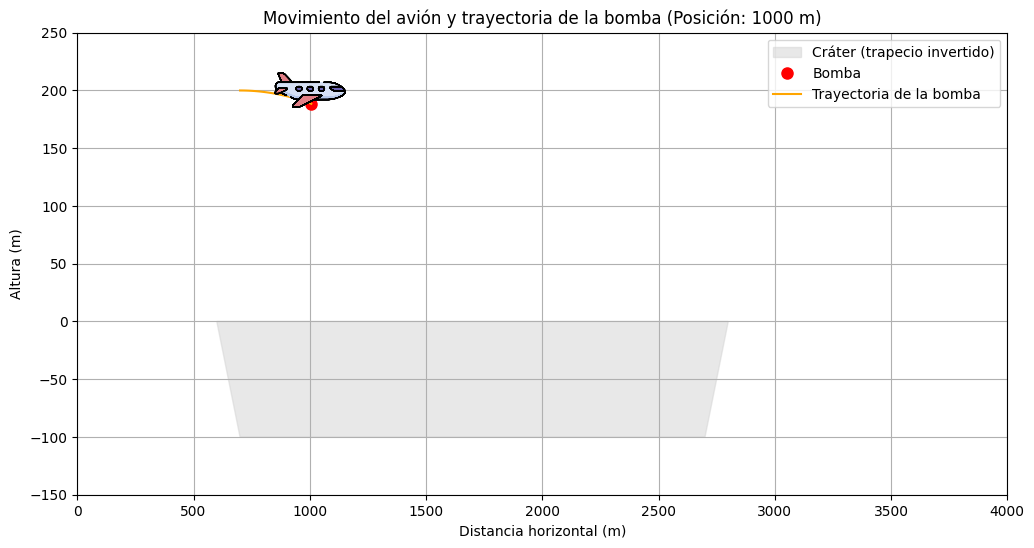

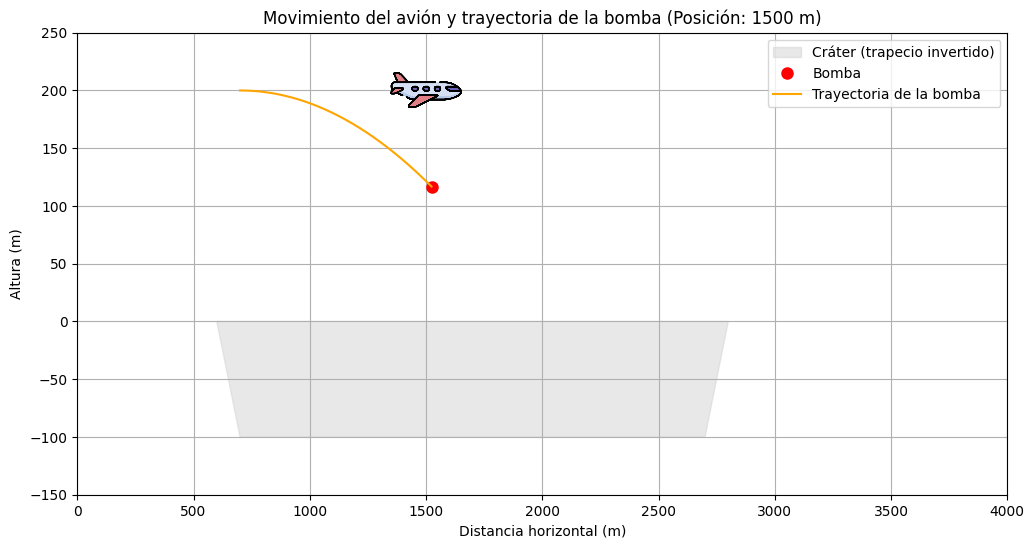

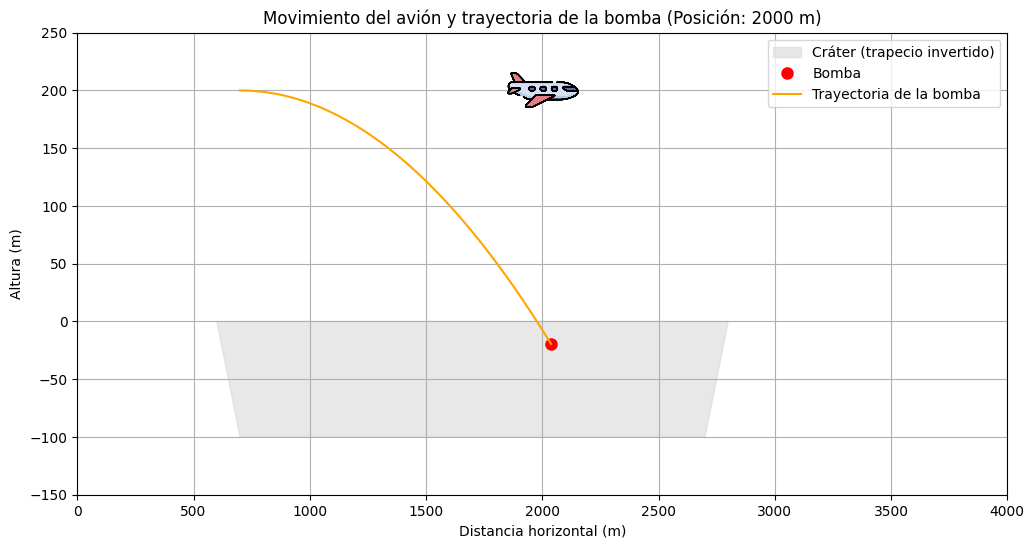

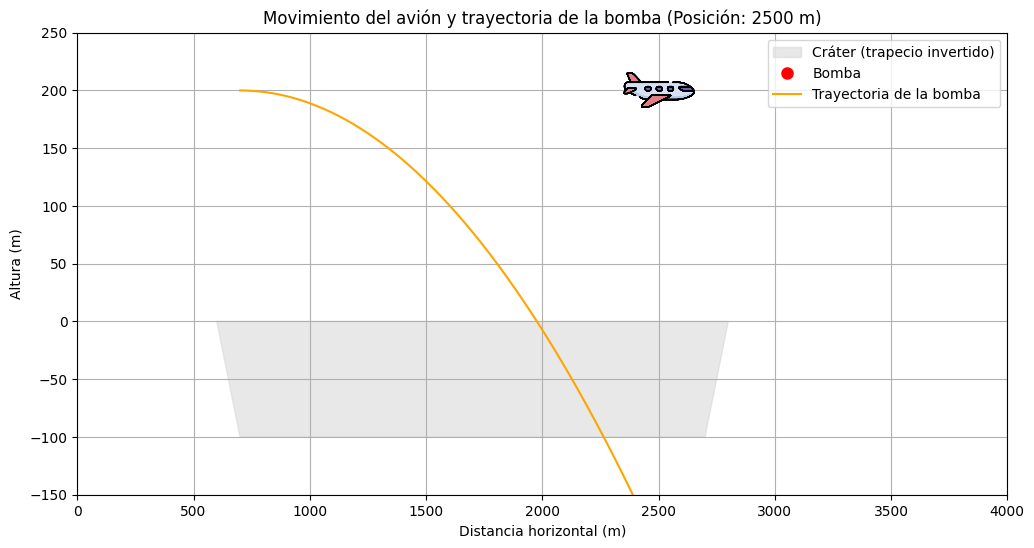

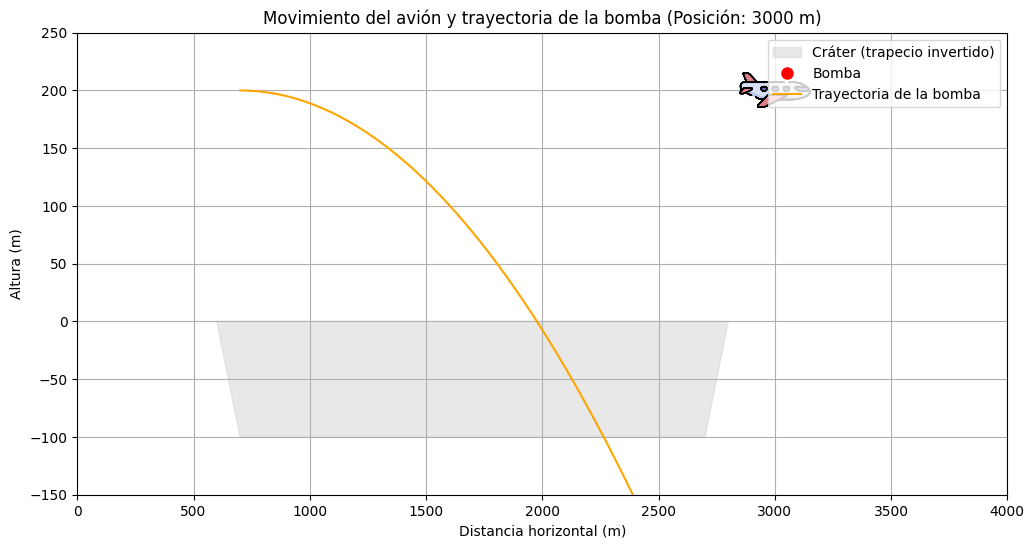

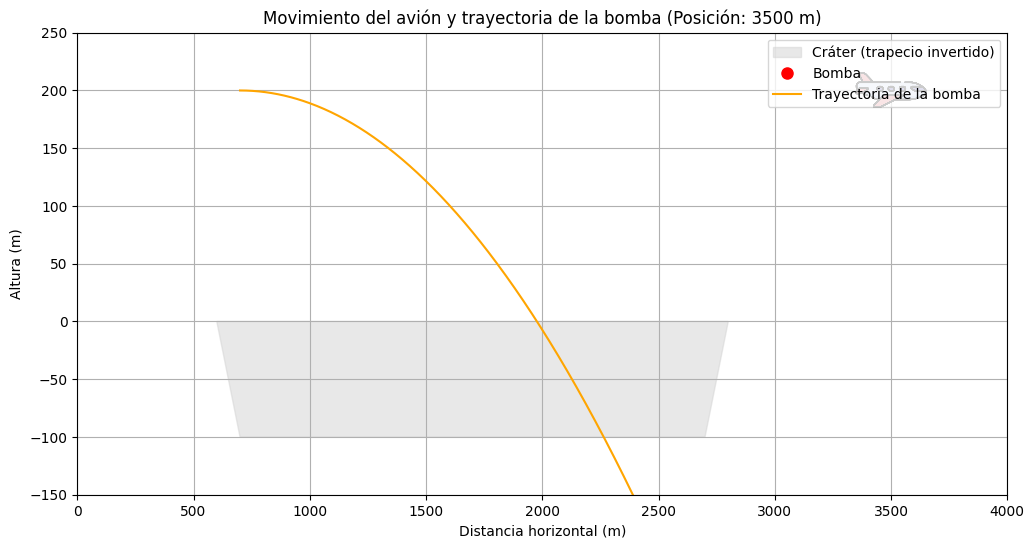

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Parámetros
ha = 200  # Altura inicial del avión
hc = -100  # Altura del fondo del cráter
L = 2000  # Longitud horizontal del cráter
alpha = np.radians(45)  # Ángulo de las paredes del cráter
d = 700  # Distancia inicial del avión desde el borde del cráter
v0 = 200  # Velocidad inicial de la bomba

v0x = v0
v0y = 0
g = 9.81

# Función de trayectoria de la bomba
def trayectoria(x, x0, y0, v0x, v0y):
    t = (x - x0) / v0x
    return y0 + v0y * t - 0.5 * g * t**2

# Coordenadas del cráter
x_crater = [
    d,
    d + (hc / np.tan(alpha)),
    d + L - (hc / np.tan(alpha)),
    d + L
]
y_crater = [hc, 0, 0, hc]

# Trayectoria de la bomba
x0 = d
y0 = ha
x_trayectoria = np.linspace(x0, x0 + L + 2 * d, 1000)
y_trayectoria = trayectoria(x_trayectoria, x0, y0, v0x, v0y)

# Detectar impacto
impacto_x = None
impacto_y = None
for i in range(len(x_trayectoria)):
    if y_trayectoria[i] <= hc:
        impacto_x = x_trayectoria[i]
        impacto_y = hc
        break

# Posiciones a las que el avión se moverá
posiciones = [500, 1000, 1500, 2000, 2500, 3000, 3500] 

for x_avion in posiciones:
    # Crear figura y ejes en cada paso para asegurarse de que se ve el movimiento
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlim(0, 4000)
    ax.set_ylim(hc - 50, ha + 50)

    # Dibujar el cráter
    ax.fill(x_crater, y_crater, color="lightgrey", label="Cráter (trapecio invertido)", alpha=0.5)

    # Ruta de la imagen del avión
    avion_imagen_ruta = r"C:\Users\Adrian Correa\Desktop\Proyecto-metodos\avion.png"
    img = plt.imread(avion_imagen_ruta)

    # Añadir el marcador del avión en la nueva posición
    avion_marker = AnnotationBbox(OffsetImage(img, zoom=0.1), (x_avion, ha), frameon=False)
    ax.add_artist(avion_marker)

    # Elementos de la bomba y trayectoria
    bomba, = ax.plot([], [], 'ro', label="Bomba", markersize=8)
    trayectoria_line, = ax.plot([], [], color="orange", label="Trayectoria de la bomba")

    # Si el avión pasa la posición donde lanza la bomba
    if x_avion >= d:
        # Calcular el índice correspondiente en la trayectoria
        index = min(int((x_avion - d) * len(x_trayectoria) / (4000 - d)), len(x_trayectoria) - 1)
        bomba_x = x_trayectoria[index]
        bomba_y = y_trayectoria[index]

        # Actualizar la posición de la bomba (como lista)
        bomba.set_data([bomba_x], [bomba_y])

        # Dibujar la trayectoria de la bomba
        trayectoria_line.set_data(x_trayectoria[:index + 1], y_trayectoria[:index + 1])

    # Configurar y mostrar el gráfico en cada iteración
    plt.legend()
    plt.grid()
    plt.title(f"Movimiento del avión y trayectoria de la bomba (Posición: {x_avion} m)")
    plt.xlabel("Distancia horizontal (m)")
    plt.ylabel("Altura (m)")
    plt.show()
    plt.pause(2.0)  # Pausa para que puedas ver cada etapa claramente

